Code to generate Figure 5(b) and 6 in 'Rethinking Discount Regularization'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
#import seaborn as sns
import torch
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import PercentFormatter
import pickle

## Define MDP

In [ ]:
def define_mdp():
  """River swim environment

  from: https://papers.nips.cc/paper/2013/file/6a5889bb0190d0211a991f47bb19a777-Paper.pdf

  """
  R=np.array([[5./1000,0,0,0,0,0],[0,0,0,0,0,1]])
  num_states = len(R[0])

  T_left = np.zeros((num_states,num_states))
  T_left[0][0] = 1
  for s in range(1,num_states):
    T_left[s][s-1] = 1

  T_right = .6*np.eye(num_states)
  T_right[0][0] = .4
  T_right[0][1] = .6

  T_right[1][0] = .05
  T_right[1][2] = .35

  T_right[2][1] = .05
  T_right[2][3] = .35

  T_right[3][2] = .05
  T_right[3][4] = .35

  T_right[4][3] = .05
  T_right[4][5] = .35

  T_right[5][4] = .40

  return [T_left,T_right],R

T_list,R = define_mdp()

## Dynamic Programming

In [ ]:
def eval_policy(gamma,policy,T_list,R_list,theta):
  """Policy evaluation
  """
  num_states = T_list[0].shape[0]

  index = list(zip(policy,range(num_states)))
  T_pi = np.matrix([T_list[i][j] for (i,j) in index])
  #R_pi = np.transpose(np.matrix(R_list))
  R_pi = np.array([R_list[i][j] for (i,j) in index])

  value = np.linalg.solve(np.eye(num_states)-gamma*T_pi,R_pi)

  return value

def value_iter(gamma, T_list,R_list, theta = .0001):
  """Value Iteration
  """
  num_states = T_list[0].shape[0]

  T = torch.tensor(np.array([np.array(x) for x in T_list]))
  R = torch.tensor(np.array(R_list))

  #V = torch.tensor(np.zeros(10))
  V = torch.tensor(np.random.uniform(0,1,num_states))
  delta = 10.

  while delta > theta:
      v = V
      V = torch.max(R + gamma*torch.einsum("bij,j->bi", T, V),dim=0).values
      delta= torch.max(torch.abs(v-V)).item()

  #get greedy policy
  P = torch.max(R + gamma*torch.einsum("bij,j->bi", T, V),dim=0).indices

  return np.array(P),np.array(V)



## Generate Data Set

In [ ]:
# sample data from MDP
#generate trajectories starting at S

def gen_trajectory(T_list,R_list,start_state_weights,action_weights,len_traj):

    num_states = T_list[0].shape[0]
    num_actions = len(T_list)
    all_actions = range(num_actions)

    traj = []
    obs_rewards = [[ [] for i in range(num_states)] for a in range(num_actions)]

    actions = []

    all_states = range(num_states)
    state = np.random.choice(all_states,1,True,start_state_weights)[0]  # start at random state with uniform prob
    traj.append(state)

    while len(traj)<len_traj:

        # choose random action
        action = np.random.choice(all_actions,p=action_weights)
        actions.append(action)

        for a in all_actions:
            if action == a:
                t_probs = T_list[a][state].tolist()
        cum_tprobs = np.cumsum(t_probs)
        rand_num = np.random.uniform()
        for j in range(num_states):
            if rand_num < cum_tprobs[j]:
                state = j
                break
        traj.append(state)

        rew_stdev = .1*abs(R_list[action][state])
        obs_rewards[action][state].append(np.random.normal(R_list[action][state],rew_stdev))

    return actions,traj,obs_rewards


#gen dataset of trajectories
def gen_data(num_traj,T_list,R_list,start_state_weights,len_traj,exact=False):

    #num_traj is number of trajectories in the data set TOTAL

    num_states = T_list[0].shape[0]
    num_actions = len(T_list)
    all_actions = range(num_actions)

    sa_count_list = []
    for a in all_actions:
        sa_count_list.append(np.zeros((num_states,num_states)))

    r_counts = obs_rewards = [[ [] for i in range(num_states)] for a in range(num_actions)]

    act_weights = [1./num_actions for n in range(num_actions)]

    if exact == False:

        for i in range(num_traj):
            actions,traj,rew = gen_trajectory(T_list,R_list,start_state_weights,act_weights,len_traj)

            for j in range(len(actions)):
                state_1 = traj[j]
                state_2 = traj[j+1]
                action = actions[j]

                for a in all_actions:
                    if action == a:
                        sa_count_list[a][state_1,state_2]+=1

            for a in range(len(r_counts)):
              r_counts[a] = [m+n for m,n in zip(rew[a],r_counts[a])]

    else:
        start_state_nums = [int(u*num_traj/num_actions) for u in start_state_weights]
        for state in range(num_states):

            start_state_weights_exact= np.zeros(num_states)
            start_state_weights_exact[state] = 1

            for a in range(num_actions):
                act_weights = np.zeros(len(T_list))
                act_weights[a] = 1

                for j in range(start_state_nums[state]):
                    actions,traj,rew = gen_trajectory(T_list,R_list,start_state_weights_exact,act_weights,len_traj)
                    for j in range(len(actions)):
                        state_1 = traj[j]
                        state_2 = traj[j+1]
                        action = actions[j]

                        for a in all_actions:
                            if action == a:
                                sa_count_list[a][state_1,state_2]+=1
                    r_counts = [m+n for m,n in zip(rew,r_counts)]

    for a in all_actions:
        sa_count_list[a] = np.matrix(sa_count_list[a])

    return sa_count_list,r_counts

## Estimate MDP

In [ ]:
#Estimate MDP
# default T if no data: uniform
# default R if no data: 0

def mle_estimate_mdp(count_matrix_list,rew_list):

    num_states = count_matrix_list[0].shape[0]
    all_actions = range(len(count_matrix_list))

    #estimate transition matrix from data

    #assume equal probability to all states as default if no data
    default = (1./num_states)*np.ones(num_states)

    T_hat_list = []
    for a in all_actions:
        T_hat_list.append(np.zeros((num_states,num_states))) #transition matrix under action a

    for i in range(num_states):

        for act in all_actions:
            sum_act = count_matrix_list[act][i].sum(axis=1)

            if sum_act == 0: # never visited state i and took action "act"
                T_hat_list[act][i] = default
            else:
                T_hat_list[act][i] = (1./sum_act)*count_matrix_list[act][i]

    #estimate reward from data
    R_hat = []
    for a in all_actions:
      R_hat.append([np.average(r) for r in rew_list[a]])
    #print(R_hat)
    R_hat = np.where(np.isnan(R_hat),0,R_hat) #assume R_hat = 0 if no data for state

    for a in all_actions:
        T_hat_list[a] = np.matrix(T_hat_list[a])

    return T_hat_list,R_hat

## Regularization

In [ ]:
#create regularized estimates

def epsilon_greedy(eps,T_hat_list):
    T_reg_list = []
    num_actions = len(T_hat_list)
    T_eg = (1./num_actions)*sum(T_hat_list)  #average of all actions, for epsilon-stochastic
    for T_hat in T_hat_list:
        T_reg_list.append((1-eps)*T_hat + eps*T_eg)
    return T_reg_list

#below was approx translates epsilon to prior magnitude on per-sa basis
#Switch to using avg of sa-counts to do same magnitude for all

def uniform_prior(eps,sa_count_list):
    T_unif_list = []
    num_states = sa_count_list[0].shape[0]
    num_actions = len(sa_count_list)
    unif_prior = np.ones((num_states,num_states))

    total_sa_count = 0
    for sa_count in sa_count_list:
      total_sa_count += np.sum(sa_count)
    avg_count = total_sa_count/(num_states*num_actions)
    mag = eps/(1-eps)*avg_count/num_states

    for sa_count in sa_count_list:
        if eps == 1:
            alpha_post = 0*sa_count+unif_prior
        else:
            alpha_post = sa_count + mag*unif_prior

        T_post = np.zeros((num_states,num_states))
        default = (1./num_states)*np.ones(num_states) #uniform default, as above
        for i in range(num_states):
            sum_state = (alpha_post[i].sum(axis=1)).item()
            if sum_state == 0: # never visited state i and took action "act"
                T_post[i] = default
            else:
                T_post[i] = (1./sum_state)*alpha_post[i]
        T_unif_list.append(T_post)

    return T_unif_list


In [ ]:
def leftright_prior(eps,sa_count_list):
    T_unif_list = []
    num_states = sa_count_list[0].shape[0]
    num_actions = len(sa_count_list)
    right_prior = np.zeros((num_states,num_states))
    left_prior = np.zeros((num_states,num_states))

    for i in range(num_states-1):
      right_prior[i][i+1] = 1
    right_prior[num_states-1][0] = 1

    for i in range(1,num_states):
      left_prior[i][i-1]=1
    left_prior[0][num_states-1] = 1

    total_sa_count = 0
    for sa_count in sa_count_list:
      total_sa_count += np.sum(sa_count)
    avg_count = total_sa_count/(num_states*num_actions)
    mag = eps/(1-eps)*avg_count/num_states

    for i,sa_count in enumerate(sa_count_list):
        if i ==0:
          prior = left_prior
        else:
          prior=right_prior

        if eps == 1:
            alpha_post = 0*sa_count+prior
        else:
            alpha_post = sa_count + mag*prior

        T_post = np.zeros((num_states,num_states))
        default = (1./num_states)*np.ones(num_states) #uniform default, as above
        for i in range(num_states):
            sum_state = (alpha_post[i].sum(axis=1)).item()
            if sum_state == 0: # never visited state i and took action "act"
                T_post[i] = default
            else:
                T_post[i] = (1./sum_state)*alpha_post[i]
        T_unif_list.append(T_post)

    return T_unif_list

### State-specific Regularization

In [ ]:
def epsilon_star_unif(T_sa,num_samples):
  """Calculate optimal value of epsilon for uniform prior

  Optimal epsilon if we knew true value of T

  """
  num_states = len(T_sa)
  numerator = 0
  denominator = 0
  for s_prime in range(num_states):
    numerator += (1./num_samples)*T_sa[s_prime]*(1-T_sa[s_prime])
    denominator += ((1./num_samples)*T_sa[s_prime]*(1-T_sa[s_prime]) + T_sa[s_prime]**2 - 2/num_states*T_sa[s_prime] + 1/(num_states**2))
  return numerator/denominator

In [ ]:
def mse_unif(T_sa,epsilon,num_samples):
  mse = 0
  num_states = len(T_sa)
  for s_prime in range(num_states):
    mse += (1-epsilon)**2*(1/num_samples)*T_sa[s_prime]*(1-T_sa[s_prime])+epsilon**2*((1/num_states)-T_sa[s_prime])**2

  return mse

In [ ]:
def epsilon_star_hat_unif(sa_count_list):

  """Calculate optimal value of epsilon for uniform prior

  Optimal epsilon for single s-a pair for when we do not know true T

  """
  epsilon_list = np.linspace(0,1,100)
  num_resamples = 100
  prior_mag = .25

  max_mse_by_eps = []
  mean_mse_by_eps = []
  mse = 0
  num_samples = sum(sa_count_list)

  #define posterior. T_sa ~ dirichlet(alpha)
  scale = 100 #need to set this!
  alpha = tuple(x+prior_mag for x in sa_count_list)
  for e in epsilon_list:

    mse_list = []
    for n in range(num_resamples):

      #sample new T-hat from posterior
      T_samp = np.random.dirichlet(alpha)

      #calc MSE
      try:
        mse = mse_unif(T_samp,e,num_samples)
      except:
        mse = mse_unif(T_samp,e,1)
      mse_list.append(mse)

    #max_mse_by_eps.append(max(mse_list))
    mean_mse_by_eps.append(np.mean(mse_list))

  #min_index = max_mse_by_eps.index(min(max_mse_by_eps))
  min_index = mean_mse_by_eps.index(min(mean_mse_by_eps))

  return epsilon_list[min_index]


In [ ]:
def T_reg_unif_per_state(T_mle_list,sa_count_list,cross_validate=False):

  """State-specific regularization calculating epsilon* without access to true T
  """

  num_states = T_mle_list[0].shape[0]
  num_actions = len(T_mle_list)
  T_reg_list = []
  T_unif = (1./num_states)*np.ones(num_states)

  T_sa_reg_list = [] #list of regularized transition matrixes for each action
  for a in range(num_actions):
    T_sa_reg = [] #action a regularized matrix
    num_samples_a = sa_count_list[a].sum(axis=1).tolist()
    for row_num in range(num_states):
      #print('state',row_num)
      num_sa_samples = num_samples_a[row_num][0]
      if cross_validate==True:
        eps_sa = epsilon_star_hat_unif(sa_count_list[a].tolist()[row_num])
        #print('eps_sa',eps_sa)
      else:
        try:
          eps_sa = epsilon_star_unif(T_mle_list[a].tolist()[row_num],num_sa_samples)
          #print('eps_sa',eps_sa)
        except:
          eps_sa = 1
          #print('no data')

      T_sa_reg.append([(1-eps_sa)*x + eps_sa*y for (x,y) in zip(T_mle_list[a].tolist()[row_num],T_unif)])
    T_sa_reg_list.append(np.matrix(T_sa_reg))

  return T_sa_reg_list

In [ ]:
def T_reg_unif_per_state_trueT(T_list,T_mle_list,sa_count_list):

  """State-specific regularization calculating epsilon* using true T

  (Theoretical minimum loss using our method)

  """
  num_states = T_list[0].shape[0]
  num_actions = len(T_list)
  T_reg_list = []
  T_unif = (1./num_states)*np.ones(num_states)

  T_sa_reg_list = [] #list of regularized transition matrixes for each action
  for a in range(num_actions):
    T_sa_reg = [] #action a regularized matrix
    num_samples_a = sa_count_list[a].sum(axis=1).tolist()
    for row_num in range(num_states):
      num_sa_samples = num_samples_a[row_num][0]
      if num_sa_samples > 0:
        eps_sa = epsilon_star_unif(T_list[a].tolist()[row_num],num_sa_samples)
      else:
        eps_sa = 1

      T_sa_reg.append([(1-eps_sa)*x + eps_sa*y for (x,y) in zip(T_mle_list[a].tolist()[row_num],T_unif)])
    T_sa_reg_list.append(np.matrix(T_sa_reg))

  return T_sa_reg_list

## Loss by value of Epsilon for Plot

In [ ]:
def calc_loss(epsilon_list, num_traj=5, len_traj = 2,num_datasets=100):

    gamma_eval = 0.99
    theta = .0001

    T_list,R_list = define_mdp()

    num_states = len(R_list[0])
    start_state_weights_data = (1./num_states)*np.ones(num_states)
    start_state_weights = (1./num_states)*np.ones(num_states) #evalulation

    #store loss for each value of epsilon
    loss_dict_disc = {} #discount regularization
    loss_dict_eg = {} #epsilon-greedy regularization
    loss_dict_unif = {} #uniform prior
    loss_dict_lr = {} #identity prior
    for e in epsilon_list:
        loss_dict_disc[e] = [] #discountf regularization
        loss_dict_eg[e] = [] #epsilon-greedy regularization
        loss_dict_unif[e] = [] #uniform prior
        loss_dict_lr[e] = [] #identity prior

    #loss for state-specfic
    loss_list_unif_ss_cv = [] #state specific with epsilon found by cv
    loss_list_unif_ss_MLE = [] #state specific with epsilon found using t-mle
    loss_list_unif_ss_TrueT = [] #state specific with epsilon found using true T

    p_dict_disc = {} #discount regularization
    p_dict_eg = {} #epsilon-greedy regularization
    p_dict_unif = {} #uniform prior
    for e in epsilon_list:
        p_dict_disc[e] = np.zeros(num_states) #discountf regularization
        p_dict_eg[e] = np.zeros(num_states) #epsilon-greedy regularization
        p_dict_unif[e] = np.zeros(num_states) #uniform prior

    #true optimal policy
    p,v = value_iter(gamma_eval,T_list,R_list,theta=1e-5)

    for n in range(num_datasets):
        if n%10==0:
          print(n)

        #data set of trajectories
        sa_count_list,r_counts = gen_data(num_traj,T_list=T_list,R_list=R_list,start_state_weights=start_state_weights_data,len_traj=len_traj,exact=False)

        T_mle_list,R_mle = mle_estimate_mdp(sa_count_list,r_counts)

        #state specific epsilon losses - unif WITH CV
        T_unif_ss_list = T_reg_unif_per_state(T_mle_list,sa_count_list,cross_validate=True)
        p_unif_ss,v_unif_ss = value_iter(gamma_eval,T_unif_ss_list,R_list)
        v_unif_ss = eval_policy(gamma_eval,p_unif_ss,T_list,R_list,theta) #calculate value of policy in true MDP
        loss_unif_ss = v - v_unif_ss
        loss_unif_ss = np.average(loss_unif_ss,axis=None,weights=start_state_weights)
        loss_list_unif_ss_cv.append(loss_unif_ss)

        #state specific - Using true T
        T_unif_ss_list2 = T_reg_unif_per_state_trueT(T_list,T_mle_list,sa_count_list)
        p_unif_ss2,v_unif_ss2 = value_iter(gamma_eval,T_unif_ss_list2,R_list)
        v_unif_ss2 = eval_policy(gamma_eval,p_unif_ss2,T_list,R_list,theta) #calculate value of policy in true MDP
        loss_unif_ss2 = v - v_unif_ss2
        #loss_unif_ss_flattened2 = [item.item() for sublist in loss_unif_ss2 for item in sublist]
        loss_unif_ss2 = np.average(loss_unif_ss2,axis=None,weights=start_state_weights)
        loss_list_unif_ss_TrueT.append(loss_unif_ss2)

        #state specific epsilon losses - unif WITHOUT CV
        T_unif_ss_list3 = T_reg_unif_per_state(T_mle_list,sa_count_list,cross_validate=False)
        p_unif_ss3,v_unif_ss3 = value_iter(gamma_eval,T_unif_ss_list3,R_list)
        v_unif_ss3 = eval_policy(gamma_eval,p_unif_ss3,T_list,R_list,theta) #calculate value of policy in true MDP
        loss_unif_ss3 = v - v_unif_ss3
        loss_unif_ss3 = np.average(loss_unif_ss3,axis=None,weights=start_state_weights)
        loss_list_unif_ss_MLE.append(loss_unif_ss3)


        for e in epsilon_list:

            T_hat_eg = epsilon_greedy(e,T_mle_list)
            num_actions = len(sa_count_list)
            num_states = len(sa_count_list[0])
            T_hat_unif = uniform_prior(e,sa_count_list)
            T_hat_lr = leftright_prior(e,sa_count_list)

            #calculate optimal policy and its value for regularized MDPs
            #assume R known
            p_disc,v_disc = value_iter((1-e)*gamma_eval,T_mle_list,R_list,theta)
            p_eg,v_eg = value_iter(gamma_eval,T_hat_eg,R_list,theta)
            p_unif,v_unif = value_iter(gamma_eval,T_hat_unif,R_list,theta)
            p_lr,v_lr = value_iter(gamma_eval,T_hat_lr,R_list,theta)


            #calculate value of policies above using true MDP
            v_disc = eval_policy(gamma_eval,p_disc,T_list,R_list,theta)
            v_eg = eval_policy(gamma_eval,p_eg,T_list,R_list,theta)
            v_unif = eval_policy(gamma_eval,p_unif,T_list,R_list,theta)
            v_lr = eval_policy(gamma_eval,p_lr,T_list,R_list,theta)

            #loss = expected value over starting state distrib
            loss_disc = v - v_disc
            #loss_disc_flattened = [item.item() for sublist in loss_disc for item in sublist]
            loss_eg = v - v_eg
            #loss_eg_flattened = [item.item() for sublist in loss_eg for item in sublist]
            loss_unif = v - v_unif
            #loss_unif_flattened = [item.item() for sublist in loss_unif for item in sublist]
            loss_lr = v - v_lr

            loss_dict_disc[e].append(np.average(loss_disc,axis=None,weights=start_state_weights))
            loss_dict_eg[e].append(np.average(loss_eg,axis=None,weights=start_state_weights))
            loss_dict_unif[e].append(np.average(loss_unif,axis=None,weights=start_state_weights))
            loss_dict_lr[e].append(np.average(loss_lr,axis=None,weights=start_state_weights))

    #mean loss
    mean_loss_disc = []
    mean_loss_eg = []
    mean_loss_unif = []
    mean_loss_lr = []
    for e in epsilon_list:
        mean_loss_disc.append(np.mean(loss_dict_disc[e]))
        mean_loss_eg.append(np.mean(loss_dict_eg[e]))
        mean_loss_unif.append(np.mean(loss_dict_unif[e]))
        mean_loss_lr.append(np.mean(loss_dict_lr[e]))

    #stdev loss of MEAN loss
    stdev_loss_disc = []
    stdev_loss_eg = []
    stdev_loss_unif = []
    stdev_loss_lr = []
    for e in epsilon_list:
        stdev_loss_disc.append(np.std(loss_dict_disc[e])/np.sqrt(num_datasets))
        stdev_loss_eg.append(np.std(loss_dict_eg[e])/np.sqrt(num_datasets))
        stdev_loss_unif.append(np.std(loss_dict_unif[e])/np.sqrt(num_datasets))
        stdev_loss_lr.append(np.std(loss_dict_lr[e])/np.sqrt(num_datasets))

    return mean_loss_disc,mean_loss_eg,mean_loss_unif,stdev_loss_disc,stdev_loss_eg,stdev_loss_unif,np.mean(loss_list_unif_ss_cv),np.mean(loss_list_unif_ss_TrueT),np.mean(loss_list_unif_ss_MLE),np.std(loss_list_unif_ss_cv)/np.sqrt(num_datasets),np.std(loss_list_unif_ss_TrueT)/np.sqrt(num_datasets),np.std(loss_list_unif_ss_MLE)/np.sqrt(num_datasets)

## Plot Results

In [ ]:
epsilon_list = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]
num_datasets = 5000
len_traj = 20
num_traj = 5

mean_loss_disc, mean_loss_eg, mean_loss_unif,stdev_loss_disc,stdev_loss_eg,stdev_loss_unif,loss_unif_ss_cv,loss_list_unif_ss_trueT,loss_unif_ss_mle,stdev_loss_ss_cv,stdev_loss_ss_trueT,stdev_loss_ss_mle = calc_loss(epsilon_list,num_traj,len_traj,num_datasets)

with open('/content/gdrive/My Drive/RegularizationJournalPlots/mean_loss_disc_riverswim.pkl', 'wb') as f:
  pickle.dump(mean_loss_disc, f)
with open('/content/gdrive/My Drive/RegularizationJournalPlots/mean_loss_eg_riverswim.pkl', 'wb') as f:
  pickle.dump(mean_loss_eg, f)
with open('/content/gdrive/My Drive/RegularizationJournalPlots/mean_loss_unif_riverswim.pkl', 'wb') as f:
  pickle.dump(mean_loss_unif, f)

with open('/content/gdrive/My Drive/RegularizationJournalPlots/stdev_loss_disc_riverswim.pkl', 'wb') as f:
  pickle.dump(stdev_loss_disc, f)
with open('/content/gdrive/My Drive/RegularizationJournalPlots/stdev_loss_eg_riverswim.pkl', 'wb') as f:
  pickle.dump(stdev_loss_eg, f)
with open('/content/gdrive/My Drive/RegularizationJournalPlots/stdev_loss_unif_riverswim.pkl', 'wb') as f:
  pickle.dump(stdev_loss_unif, f)


with open('/content/gdrive/My Drive/RegularizationJournalPlots/loss_unif_ss_cv_riverswim.pkl', 'wb') as f:
  pickle.dump(loss_unif_ss_cv, f)
with open('/content/gdrive/My Drive/RegularizationJournalPlots/loss_list_unif_ss_trueT_riverswim.pkl', 'wb') as f:
  pickle.dump(loss_list_unif_ss_trueT, f)
with open('/content/gdrive/My Drive/RegularizationJournalPlots/loss_list_unif_ss_mle_riverswim.pkl', 'wb') as f:
  pickle.dump(loss_unif_ss_mle, f)

with open('/content/gdrive/My Drive/RegularizationJournalPlots/stdev_loss_ss_cv_riverswim.pkl', 'wb') as f:
  pickle.dump(stdev_loss_ss_cv, f)
with open('/content/gdrive/My Drive/RegularizationJournalPlots/stdev_loss_ss_trueT_riverswim.pkl', 'wb') as f:
  pickle.dump(stdev_loss_ss_trueT, f)
with open('/content/gdrive/My Drive/RegularizationJournalPlots/stdev_loss_ss_mle_riverswim.pkl', 'wb') as f:
  pickle.dump(stdev_loss_ss_mle, f)

0


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

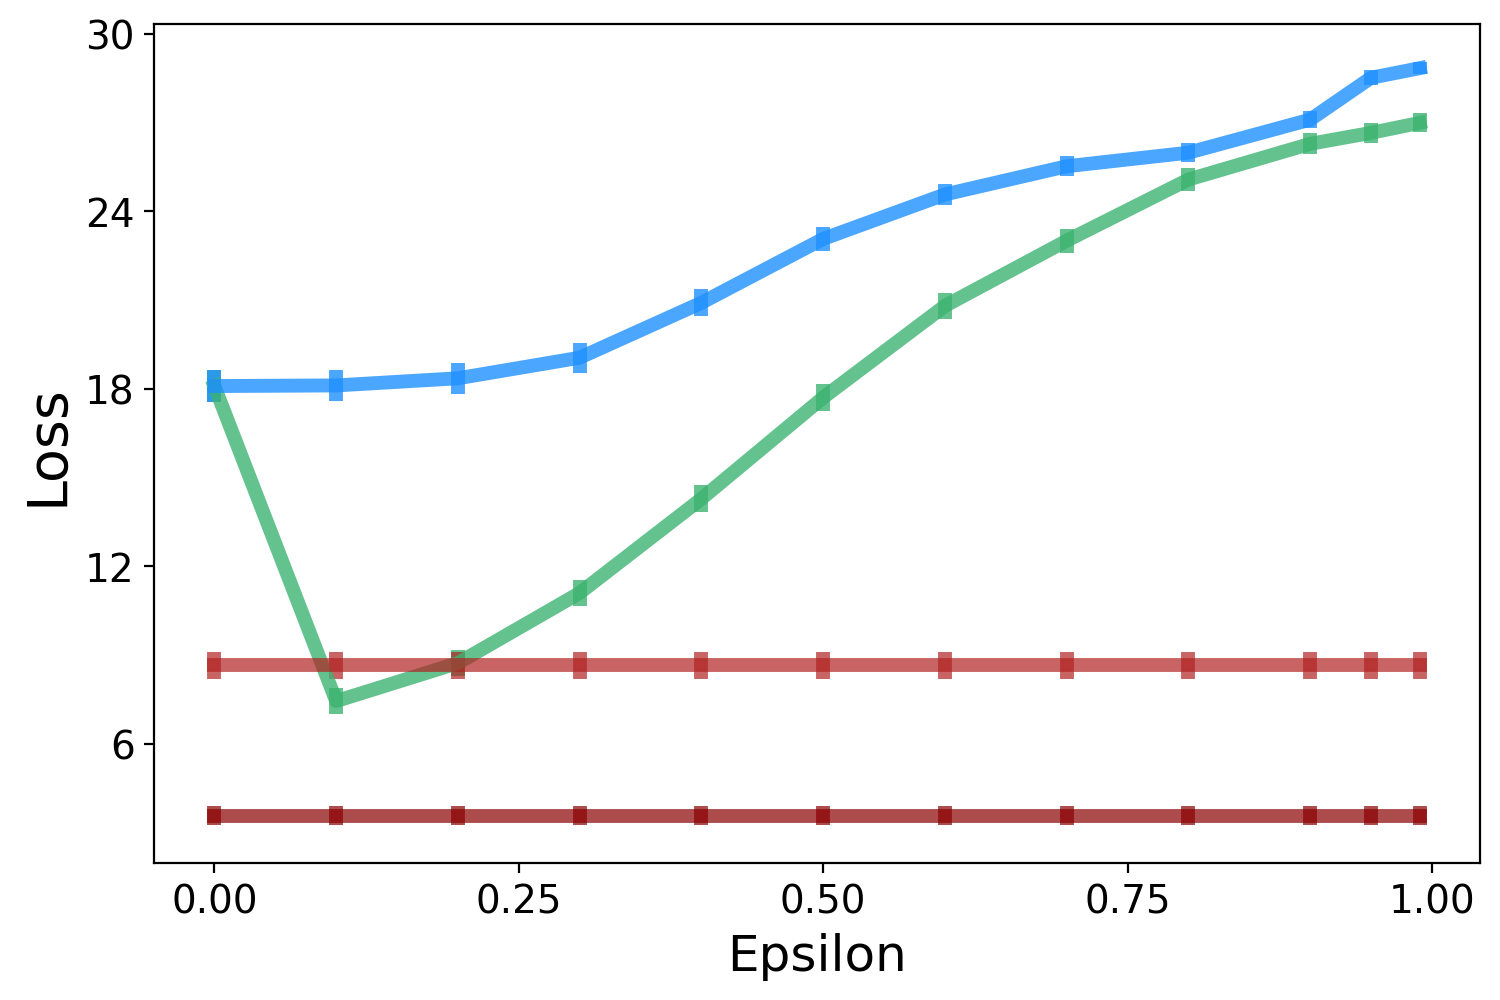

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,6),dpi=200)
#ax.errorbar(epsilon_list, mean_loss_eg, yerr=[2*j for j in stdev_loss_eg],color='violet',label = 'Epsilon-Greedy',alpha=.8,linewidth = 5.0)
ax.errorbar(epsilon_list, mean_loss_unif, yerr=[2*j for j in stdev_loss_unif],color='mediumseagreen',label = 'Uniform Prior',alpha=.8,linewidth = 5.0)
ax.errorbar(epsilon_list, mean_loss_disc, yerr=[2*j for j in stdev_loss_disc],label = 'Discount Regularization',alpha=.8,linewidth = 5.0,color='dodgerblue')
ax.errorbar(epsilon_list,[loss_unif_ss_cv for i in epsilon_list],yerr=[2*stdev_loss_ss_cv for j in epsilon_list],color='firebrick',linewidth = 5.0,alpha = .7, label = r"State-action specfic $\epsilon$")
ax.errorbar(epsilon_list,[loss_list_unif_ss_trueT for i in epsilon_list],yerr=[2*stdev_loss_ss_trueT for j in epsilon_list],color='darkred',linewidth = 5.0,alpha = .7, label = r"State-Action Specfic Oracle")

ax.set_xlabel("Epsilon",fontsize=18)
ax.set_ylabel("Loss",fontsize=20)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.tick_params(axis='both', which='major', labelsize=14)

#ax.legend(fontsize=12)

fig.tight_layout(rect=[0.05, 0, 1, 0.85])
plt.savefig('/content/gdrive/My Drive/RegularizationJournalPlots/riverswim_nolegend.pdf')

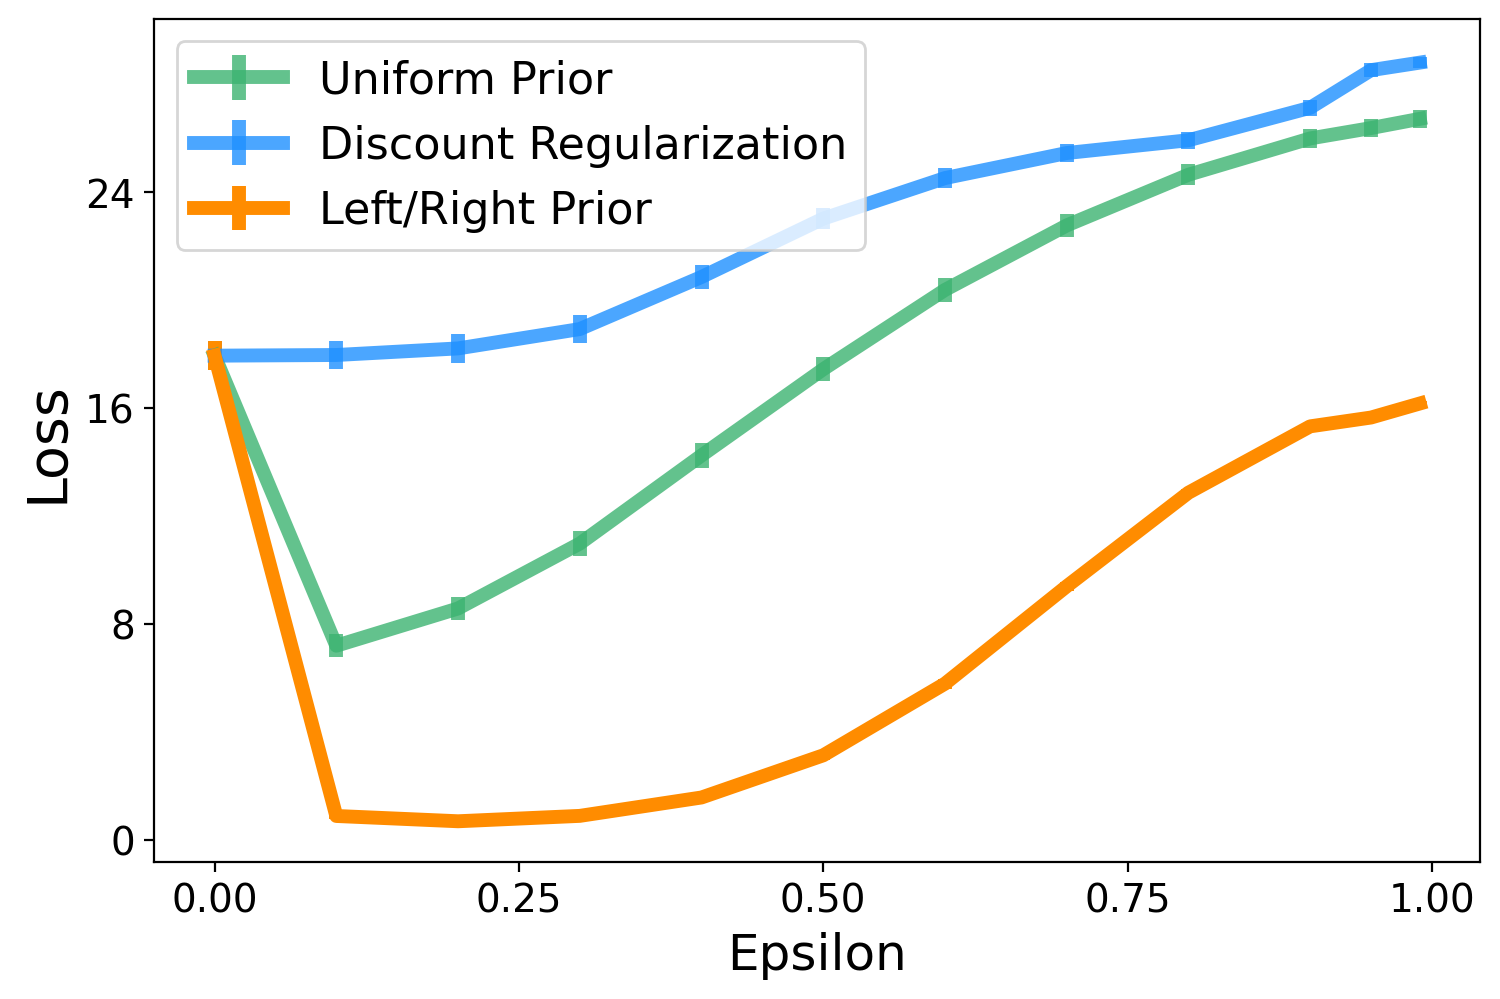

In [ ]:
epsilon_list = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]
num_datasets = 5000
len_traj = 20
num_traj = 5

mean_loss_disc, mean_loss_eg, mean_loss_unif,mean_loss_lr,stdev_loss_disc,stdev_loss_eg,stdev_loss_unif,stdev_loss_lr,loss_unif_ss_cv,loss_list_unif_ss_trueT,loss_unif_ss_mle,stdev_loss_ss_cv,stdev_loss_ss_mle = calc_loss(epsilon_list,num_traj,len_traj,num_datasets)

fig,ax = plt.subplots(1,1,figsize=(8,6),dpi=200)
#ax.plot(epsilon_list,mean_loss_unif,label = 'Uniform Prior',alpha=.8,linewidth = 5.0,color='#3a98c7')
ax.errorbar(epsilon_list, mean_loss_unif, yerr=[2*j for j in stdev_loss_unif],label = 'Uniform Prior',linewidth=5.0,alpha=.80,color='mediumseagreen')
#ax.plot(epsilon_list,mean_loss_disc,label = 'Discount Regularization',alpha=.8,linewidth = 5.0,color='#ed6a47')
ax.errorbar(epsilon_list, mean_loss_disc, yerr=[2*j for j in stdev_loss_disc],label = 'Discount Regularization',linewidth=5.0,alpha=.80,color='dodgerblue')
#ax.plot(epsilon_list,mean_loss_lr,label = 'Left/Right Prior',alpha=.8,linewidth = 5.0,color='firebrick')
ax.errorbar(epsilon_list, mean_loss_lr, yerr=[2*j for j in stdev_loss_lr],linewidth = 5.0,color='darkorange',label='Left/Right Prior')

#ax.axhline(y=loss_unif_ss_cv, color='darkblue', linestyle='-',linewidth = 5.0,alpha = .7, label = r"State-action specfic $\epsilon$ (CV)")
#ax.errorbar(epsilon_list,[loss_unif_ss_cv for i in epsilon_list],yerr=[2*stdev_loss_ss_cv for j in epsilon_list],color='darkblue',linewidth = 5.0,alpha = .7)
#ax.axhline(y=loss_unif_ss_mle, color='teal', linestyle='-',linewidth = 5.0,alpha = .7, label = r"State-action specfic $\epsilon$ (MLE)")
#ax.errorbar(epsilon_list,[loss_unif_ss_mle for i in epsilon_list],yerr=[2*stdev_loss_ss_mle for j in epsilon_list],color='teal',linewidth = 5.0,alpha = .7)

ax.set_xlabel("Epsilon",fontsize=18)
ax.set_ylabel("Loss",fontsize=18)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel("Loss",fontsize=20)
ax.legend(fontsize=16)

fig.tight_layout(rect=[0.05, 0, 1, 0.85])
plt.savefig('river_swim_lr.pdf')